<div class="green">
    
# <span style="color:green">Consumer Complaint Response</span>
    
#### <span style="color:lightgreen">GitHubs: [Tyler Kephart](https://github.com/tkephart96) | [Chellyan Moreno](https://github.com/chellyan-moreno) | [Rosendo Lugo](https://github.com/rosendo-lugo) | [Alexia Lewis](https://github.com/lewisalexia)</span>
   
</div>

<div class="alert alert-success">    
    
## Goal: 
This classification NLP project aims to provide an accurate prediction of company response based on the language of a consumer's complaint.

## Description:

Our project involves analyzing 3.5 million consumer complaints to the Consumer Financial Protection Bureau (CFPB) from 2011 to 2023. We'll use Natural language Processing to analyze how the wording of complaints affects a company's response. Our goal is to provide insights on complaint language and its impact, helping companies improve their responses and enhancing the outcomes for consumers and businesses.
  
</div>

# <span style="color:green">Imports</span>
    

In [1]:
#local modules
import wrangle as wr
import explore as ex
import model as mo

#standard
import pandas as pd

#set random state
random_state=123

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_colwidth", 250)

imports loaded successfully, awaiting commands...


# <span style="color:green">Wrangle</span>
    

---

* <span style="color:green">Data acquired from [Google BigQuery](https://console.cloud.google.com/marketplace/product/cfpb/complaint-database)
* <span style="color:green">3,458,906 rows × 18 columns *before* cleaning
* <span style="color:green">1,246,736 rows x 8 columns *after* cleaning</span>


### <span style="color:lightgreen">Data Dictionary</span>

| Feature                               | Definition                                                                                  |
| :------------------------------------ | :------------------------------------------------------------------------------------------ |
| date_received                         | Date the complaint was received by the CFPB                                                 |
| product                               | The type of product the consumer identified in the complaint                                |
| subproduct                            | The type of sub-product the consumer identified in the complaint                            |
| issue                                 | The issue the consumer identified in the complaint                                          |
| subissue                              | The sub-issue the consumer identified in the complaint                                      |
| consumer_complaint_narrative          | A description of the complaint provided by the consumer                                     |
| company_public_response               | The company's optional public-facing response to a consumer's complaint                     |
| company_name                          | Name of the company identified in the complaint by the consumer                             |
| state                                 | Two-letter postal abbreviation of the state of the mailing address provided by the consumer |
| zip_code                              | The mailing ZIP code provided by the consumer                                               |
| tags                                  | Older American is aged 62 and older, Servicemember is Active/Guard/Reserve member or spouse |
| consumer_consent_provided             | Identifies whether the consumer opted in to publish their complaint narrative               |
| submitted_via                         | How the complaint was submitted to the CFPB                                                 |
| date_sent_to_company                  | The date the CFPB sent the complaint to the company                                         |
| company_response_to_consumer (target) | The response from the company about this complaint                                          |
| timely_response                       | Indicates whether the company gave a timely response or not                                 |
| consumer_disputed                     | Whether the consumer disputed the company's response                                        |
| complaint_id                          | Unique ID for complaints registered with the CFPB                                           |
| product_bins                          | Engineered Feature: bin related products together                                           |
| clean                                 | Engineered Feature: tokenized, numbers/specials, and XX's removed                           |
| lemon                                 | Engineered Feature: clean column PLUS lemmatization                                         |

<div class="alert alert-success">    

### Insight: 

* **Quick run**
    * Verify `import wrangle as w` is in the imports section 
    * Run final report
    * This will use a pre-built and cleaned parquet file
<br>
<br>
* **For the longer run: ⚠️WARNING⚠️:** These are almost the same steps we took to originally acquire the data. The steps take a lot of time (and space) and may not even be the best way of doing it. We highly recommend doing the quick run above unless you want to know how we got the data.
    * Verify `import big_wrangle as w` is in the imports section
    * Install the pandas-gbq package
        * `pip install pandas-gbq`
    * Go to Google BigQuery and create a project
    * Copy the `'long-SQL queries found in big_wrangle.py`
        * Run in [Google BigQuery](https://cloud.google.com/bigquery/public-data)
    * Click on 'Go to Datasets in Cloud Marketplace' and search for 'CFPB'
        * View the dataset to open a quick SQL prompt to query in
    * Save each result as a BigQuery table in your project
    * You can look in `big_wrangle.py for what we named our project, database, and tables`
    * Edit and save the `'small-SQL query variables found in big_wrangle.py` to the respective table names in your BigQuery project using this format: 
        * ***FROM 'database. table' and edit the 'project_ID' variable to your project's ID***
    * Run final report
    * It may ask for authentication when it tries to query Google BigQuery
        * Try to run again if it stopped
    * This will run through the longer pathway of getting the datasets from the source and merging/cleaning/prep
    * It will probably take a while **(3+ millions of rows, +2GB)**

</div>

# <span style="color:green">Prepare</span>  
---

### **<span style="color:lightgreen">Dropped Columns</span>**
  * **product**
    * 0% nulls
    * **<span style="color:lightblue">ENGINEERED FEATURE</span>**
    * *<span style="color:lightblue">bin related products/services together then drop</span>*
        * <span style="color:lightgreen">bins = credit_report, credit_card, debt_collection, mortgage, bank, loans, and money_service</span>
  * **subproduct**
    * 7% null
  * **issue**
    * 0% nulls
    * 165 unique values
    * **<span style="color:lightblue">future iteration</span>**
  * **subissue**
    * 20% null
    * 221 unique
  * **consumer_complaint_narrative**
    * 64% null
    * renamed to narrative
      * **<span style="color:lightblue">drop all null values</span>**
      * **<span style="color:lightblue">drop after NLTK cleaning</span>**
  * **company_public_response**
    * 56% null
    * related to target
  * **zip code**
    * 1% null
    * mixed data types
      * **<span style="color:lightblue">future iteration</span>**
  * **consumer_consent_provided**
    * 25% null
    * does not relate to the target
  * **submitted_via**
    * 0% nulls
    * does not relate to the target
  * **date_sent_to_company**
    * 0% nulls
      * **<span style="color:lightblue">future iteration</span>**
  * **timely_response**
    * 0% nulls
    * boolean
      * **<span style="color:lightblue">future iteration</span>**
  * **consumer_disputed**
    * 77% null
      * **<span style="color:lightblue">future iteration</span>**
  * **complaint_id**
    * 0% nulls
<br>

---
### **<span style="color:lightgreen">Cleaned Columns</span>**
  * **date_received**
    * 0% nulls
    * changed date to DateTime
  * **company_name**
    * 0% nulls
    * 6,694 Companies
  * **state**
    * 1% null
    * keep for purposes of exploration
      * **<span style="color:lightblue">impute 1% null into UNKNOWN label</span>**
  * **tags**
    * 89% null
        * **<span style="color:lightblue">impute nulls with "Average Person label</span>**
  * **company_response_to_consumer**
    * Target
    * 4 nulls = 0%
      * **<span style="color:lightblue">drop these 4 rows because this is the target column</span>**
    * 8 initial unique values
      * **<span style="color:lightblue">nice to have: apply the model to in_progress complaints and see what it predicts based on the language</span>**
      * **<span style="color:lightblue">drop 'in progress' response because there is no conclusion</span>**


In [2]:
# Acquire and write/read CSV
# Clean and NLTK prepare
# relatively quicker 20+ min
df = wr.wrangle_complaints()

# longer run 50+ min
# df = wr.wrangle_complaints_the_long_way()

parquet file found and loaded


<div class="alert alert-success">    

### Insight:
    
Used NLTK to clean each document resulting in:
* 2 new columns: *clean* (removes redacted XXs, and stopwords removed) and *lemon* (lemmatized)
    <br>
    <br>
    
Selected columns to proceed with after cleaning:
* date_received, product_bins, company_name, state, tags, company_response_to_customer (target), clean, lemon
    
</div>

# <span style="color:green">Explore</span>
    
---


### <span style="color:lightgreen">Split and Parquet</span>

In [3]:
# Split
train, validate, test = wr.split_data(df,"company_response_to_consumer")

# Write to Parquet
# train.to_parquet('train.parquet')
# validate.to_parquet('validate.parquet')
# test.to_parquet('test.parquet')

# Assign 
# train = pd.read_parquet('train.parquet')
# validate = pd.read_parquet('validate.parquet')
# test = pd.read_parquet('test.parquet')

Prepared DF: (1246736, 8)
Train: (748041, 8)
Validate: (249347, 8)
Test: (249348, 8)


<div class="alert alert-success">  
    
## <span style="color:darkgreen">Questions To Answer:</span>

**1. Are there words that get particular responses and is there a relationship?**
* What are the payout words that got a company response of closed with monetary relief?
* Are there unique words associated with products? Is there a relationship between unique product words and responses?
<br>

**2. Do all responses have a negative sentiment?**
* Do narratives with a neutral or positive sentiment analysis relating to bank account products lead to a response of closed with monetary relief?
<br>

**3. Are there unique words associated with the most negative and most positive company responses?**
<br>

**4. Which product is more likely to have monetary relief?**
</div>

### <span style="color:lightblue">**1. Are there words that get particular company responses and is there a relationship?**</span>

Initial Thoughts:
* Separation each word by row and then will be doing a count of how many times the word appears in the lemon column.
* Use a small sample in this case we will only use a max_features of 20,000
* Count Words: Use a tool like CountVectorizer in Python to count how often each word appears in the complaints.
* Compare: Calculate the average count of each word for each type of company response to see which words are used most often.
* Visualize: Create a barplot visual to show which words are most associated with each type of company response.
* Use your word counts to predict the company response using machine learning techniques.

In [4]:
word_counts, df_with_words,word_counts_ones = ex.get_word_counts(train)
top = ex.top_15_words(word_counts_ones)

In [5]:
top

,account,credit,report,information,payment,reporting,consumer,loan,time,would,debt,company,day,bank,card,letter
Closed with explanation,629836,606624,345155,291073,273952,216326,195691,177822,172047,166682,165795,160513,155470.0,153768,144099.0,NaN
Closed,2197,2085,1153,958,1013,776,597,726,610,650,623,599,534.0,601,NaN,547.0
Closed with monetary relief,32061,30752,17548,14648,13751,11096,10156,9105,8703,8516,8615,8100,7793.0,7848,7121.0,NaN
Closed with non-monetary relief,165738,159689,90705,76034,71415,57213,51439,45844,45424,43605,43786,41900,40188.0,40205,38068.0,NaN
Untimely response,2737,2634,1496,1256,1136,985,921,720,769,710,889,807,NaN,680,646.0,626.0


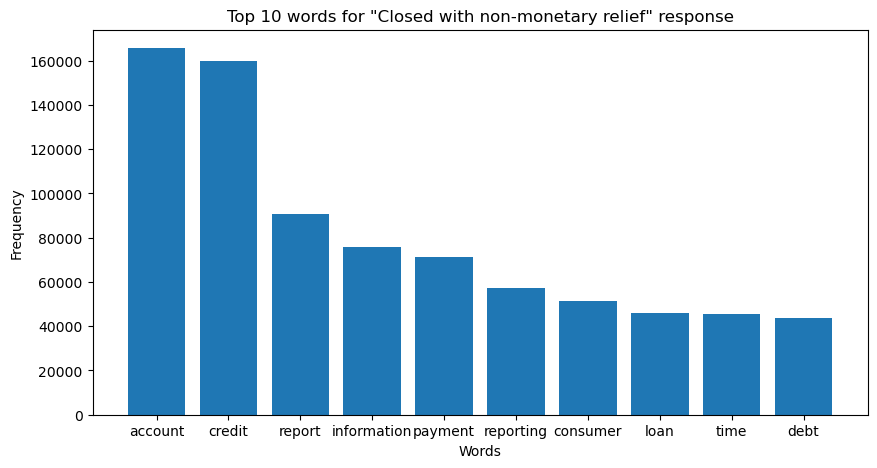

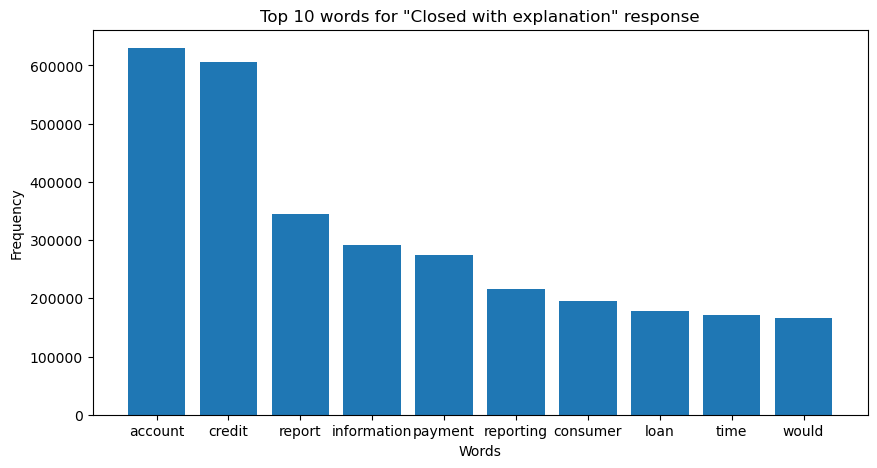

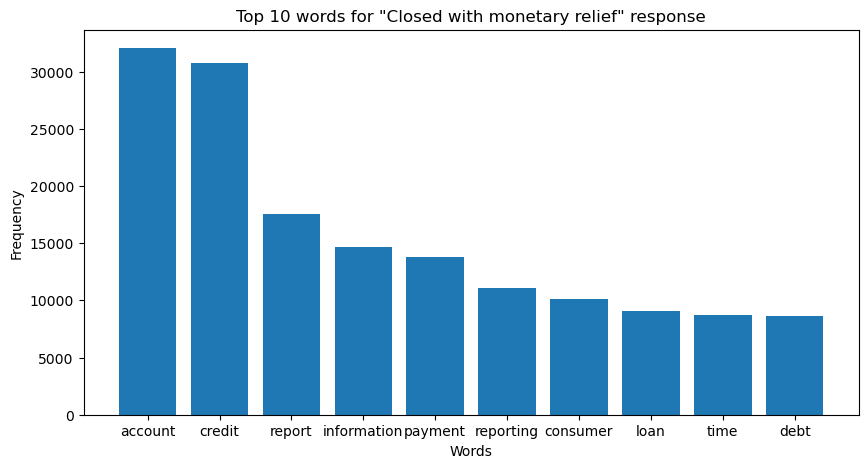

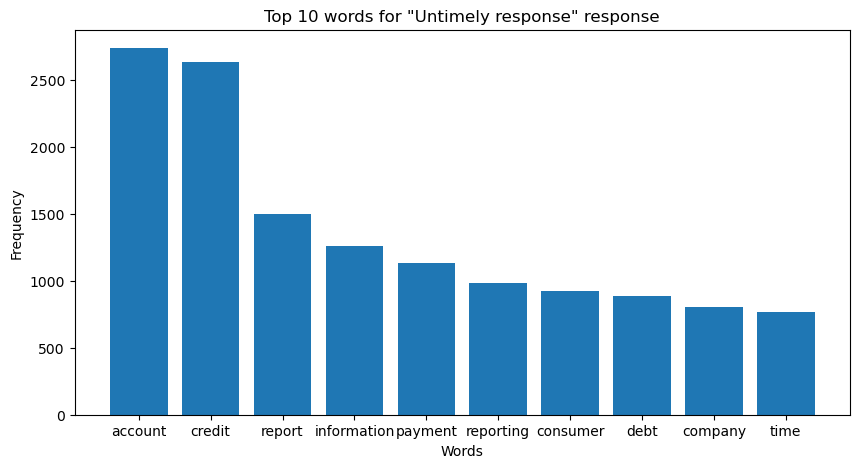

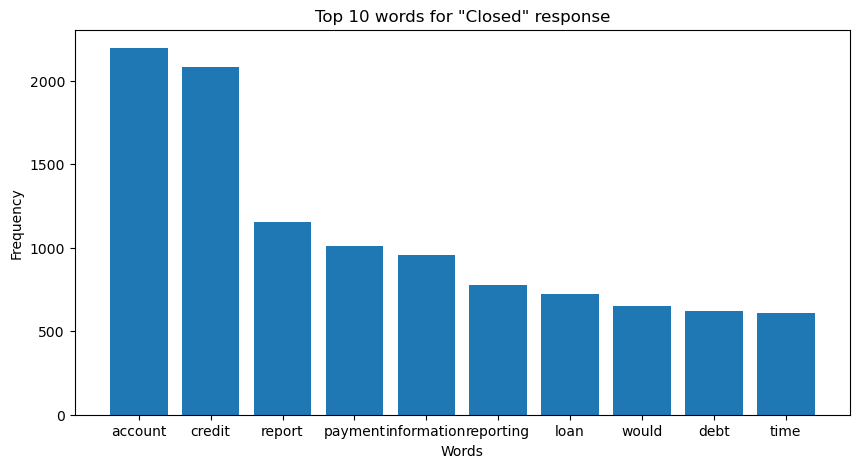

In [6]:
ex.frequent_words_plot(df_with_words,word_counts_ones)

<div class="alert alert-success">    

## Insight:
* Based on the top 15 words there are no specific words that are associated with a specific respond.   

* Common Words: 
    The most common words in all company responses are: 
    account,
    credit,
    report,
    information,
    payment,
    loan,
    time,
    would,
    debt,
    company,
    and "day"     
* No Specific Words: 
    There are no specific words that are only associated with a certain type of company response. This means companies use similar language regardless of their response type. 
    
* Account is Popular: 
    The word account is the most frequently used word in company responses. This suggests that many complaints are related to issues with accounts.  
    
* Response Types: 
    The response type "Closed with explanation" has the highest word count for all the top words. This means that companies tend to use more words when they are providing an explanation. 
    
* Less Words for "Untimely response": 
    Companies use fewer words in their responses when the response is "Untimely response". This could mean that when companies respond late, they tend to provide less detailed responses. 


</div>

### <span style="color:lightblue">**2. Do all responses have a negative sentiment?**</span>
* <span style="color:lightblue">Do narratives with a neutral or positive sentiment analysis relating to bank account products lead to a response of closed with monetary relief? </span>

$H_0$: There is no significant effect of sentiment on company response to the consumer.


$H_a$: There is a significant effect of sentiment on company response to the consumer.

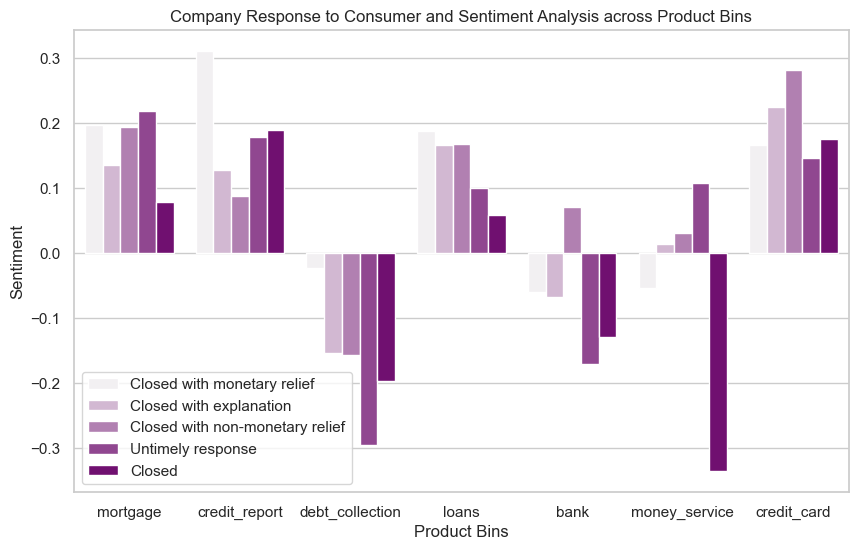

Running Levene Test...
p-value: 0.3157553080 > 0.05?

Variance is true, proceed with ANOVA test...

Product Bins: mortgage
ANOVA p-value: 1.7408191694334038e-07
There is a significant effect of sentiment on company response to the consumer.

Product Bins: credit_report
ANOVA p-value: nan
There is no significant effect of sentiment on company response to the consumer.

Product Bins: debt_collection
ANOVA p-value: nan
There is no significant effect of sentiment on company response to the consumer.

Product Bins: loans
ANOVA p-value: 0.02638166126024402
There is a significant effect of sentiment on company response to the consumer.

Product Bins: bank
ANOVA p-value: 2.766277149926247e-20
There is a significant effect of sentiment on company response to the consumer.

Product Bins: money_service
ANOVA p-value: 0.0002667227011445013
There is a significant effect of sentiment on company response to the consumer.

Product Bins: credit_card
ANOVA p-value: 1.975698971011137e-28
There is a signi

In [7]:
# visualize data and run statistical analysis
ex.analyze_sentiment(train)

<div class="alert alert-success">    

### Insight: 
#### - Overall, there is a strong correlation between the sentiment of consumer complaints/narratives and the corresponding responses from companies.

1. **Mortgage**:
  - Consumer complaints/narratives exhibit predominantly positive sentiment, and companies provide an equal distribution of responses across different categories.
  
2. **Credit Report**:
  - Consumer complaints/narratives with positive sentiment tend to receive the "closed with monetary relief" response most frequently.
  - Overall, the sentiment of complaints/narratives is generally neutral to positive.
  
3. **Debt Collection**:
  - All consumer complaints/narratives have negative sentiment scores, and the complaints with the most negative scores typically receive an "untimely response."
  
4. **Loans**:
  - Complaints/narratives regarding loans have sentiment scores ranging from neutral to positive. Companies provide different responses irrespective of the sentiment score.
   
5. **Bank**:
  - Sentiment scores for bank-related complaints/narratives are somewhat mixed, ranging from neutral to negative. The more negative complaints tend to receive a "closed" or "untimely response."
  
6. **Money Service**:
  - Sentiment scores for complaints/narratives about money services vary between negative and positive. The most negative complaints receive a "closed" response.
  
7. **Credit Card**:
 - The majority of sentiment scores for credit card complaints/narratives range from neutral to positive. The most common response received by consumers is "closed with non-monetary relief."
 
 
#### - These findings indicate that the sentiment of consumer complaints/narratives has an influence on the type of response received from companies across different industry sectors.


### <span style="color:lightblue">**3. Are there unique words associated with the most negative and most positive company responses?**</span>
* <span style="color:lightblue">Are there unique words associated with products? Is there a relationship between unique product words and responses?</span>

In [9]:
def basic_clean_split(string):
    """
    The function `basic_clean` takes a string as input and performs basic cleaning operations such as
    converting the string to lowercase, removing non-alphanumeric characters, and normalizing unicode
    characters.
    
    :param string: The parameter "string" is a string that you want to perform basic cleaning on
    :return: The function `basic_clean` returns a cleaned version of the input string.
    """
    string = string.lower()
    string = ex.unicodedata.normalize('NFKD', string).encode('ascii','ignore').decode('utf-8')
    string = ex.re.sub(r'[^a-z0-9\'\s]', ' ', string).split()
    return string

def get_words(train):
    '''
    this function extracts and counts words from a df based on different company responses.
    returns a word_count df containing the associated words for each response
    '''
    #assigning all words to proper labels
    explanation_words = basic_clean_split(' '.join(train[train.company_response_to_consumer == 'Closed with explanation'].lemon.astype(str)))
    no_money_words = basic_clean_split(' '.join(train[train.company_response_to_consumer == 'Closed with non-monetary relief'].lemon.astype(str)))
    money_words = basic_clean_split(' '.join(train[train.company_response_to_consumer == 'Closed with monetary relief'].lemon.astype(str)))
    timed_out_words = basic_clean_split(' '.join(train[train.company_response_to_consumer == 'Untimely response'].lemon.astype(str)))
    closed_words = basic_clean_split(' '.join(train[train.company_response_to_consumer == 'Closed'].lemon.astype(str)))
    all_words = basic_clean_split(' '.join(train.lemon))
    
    #grabbing frequencies of occurrences
    explanation_freq = pd.Series(explanation_words).value_counts()
    no_money_freq = pd.Series(no_money_words).value_counts()
    money_freq = pd.Series(money_words).value_counts()
    timed_out_freq = pd.Series(timed_out_words).value_counts()
    closed_freq = pd.Series(closed_words).value_counts()
    all_freq = pd.Series(all_words).value_counts()

    #combine into df to see all words and languages together
    word_counts = (pd.concat([all_freq, explanation_freq, no_money_freq, money_freq, timed_out_freq, closed_freq], axis=1, sort=True)
                .set_axis(['all', 'explanation', 'no_money', 'money', 'timed_out', 'closed'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
    
    print(f"Total Unique Words Found per Response: {word_counts.shape[0]}")
    print()
    
    return word_counts 

In [12]:
basic_clean_split(' '.join(train[train.company_response_to_consumer == 'Closed with explanation'].lemon.astype(str)))

['inquiry',
 'ive',
 'called',
 'informed',
 'applied',
 'car',
 'inquiry',
 'remove',
 'check',
 'said',
 'record',
 'system',
 'ive',
 'since',
 'contact',
 'transunion',
 'let',
 'know',
 'inquiry',
 'still',
 'credit',
 'report',
 'paid',
 'bill',
 'hope',
 'get',
 'back',
 'said',
 'pay',
 'different',
 'installation',
 'fee',
 'send',
 'equipment',
 'back',
 'wo',
 'nt',
 'charged',
 'never',
 'removed',
 'charge',
 'unknown',
 'inquiry',
 'credit',
 'report',
 'credit',
 'plus',
 'authorized',
 'verbally',
 'physically',
 'electronically',
 'application',
 'requested',
 'credit',
 'credit',
 'ran',
 'account',
 'organization',
 'also',
 'know',
 'also',
 'identity',
 'theft',
 'report',
 'filed',
 'local',
 'police',
 'department',
 'selene',
 'finance',
 'help',
 'figure',
 'many',
 'different',
 'amount',
 'used',
 'figuring',
 'payoff',
 'home',
 'foreclosing',
 'even',
 'told',
 'wanting',
 'keep',
 'home',
 'attached',
 'document',
 'sent',
 'payoff',
 'day',
 'one',
 'payo

In [13]:
# Get words per company response and per product
word_counts = ex.get_words(train).sort_values(by='all',ascending=False)
word_counts = word_counts.sort_values(by='all',ascending=False)
word_counts_products = ex.get_words_products(train)
word_counts_products = word_counts_products.sort_values(by='all',ascending=False)

TypeError: sequence item 42116: expected str instance, NoneType found

In [ ]:
# Get words per company response and per product
word_counts = ex.get_words(train).sort_values(by='all',ascending=False)
word_counts = word_counts.sort_values(by='all',ascending=False)
word_counts_products = ex.get_words_products(train)
word_counts_products = word_counts_products.sort_values(by='all',ascending=False)

TypeError: sequence item 42116: expected str instance, NoneType found

In [ ]:
# Visualize words per company response
ex.unique_words(word_counts)

In [ ]:
# Visualize words per product
ex.unique_words(word_counts_products)

<div class="alert alert-success">

## Insight:

There is a relationship between words used in complaints and company responses. The words used relate to products that consumer's can complain about. There are unique words associated with each product and those words can be used to predict a company response.
    
### Company Responses and top 5 words:

* Explanation
    * Account, Credit, Report, Payment, Information
        * This type of response looks like it could relate to credit reporting products
* Non-Monetary
    * Credit, Account, Report, Information, Reporting
* **Monetary**
    * Account, **Bank**, **Card**, Credit, Payment
        * This type of response looks like it could relate to credit card or bank products
* **Untimely Response**
    * **Debt**, Credit, Account, **Company**, **Loan**
        * This type of response looks like it could relate to debt products
* Closed
    * Account, Debt, Credit, Payment, Loan
---

### Products and top 5 words:
* Credit Report
    * Credit, Account, Report, Information, Reporting
        * matches up with hypothesis where this type of product might get a response of explanation or non-monetary relief
* Debt
    * **Debt**, Credit, Account, **Collection**, Report
        * matches up with hypothesis where this type of product might get an untimely response
* Credit Card
    * **Card**, Credit, Account, Payment, **Charge**
        * matches up with hypothesis where this type of product might get a response of monetary relief
* Mortgage
    * Payment, Loan, Mortgage, Would, **Time**
        * matches up with hypothesis where this type of product might get a response of closed
* Loans
    * Loan, Payment, Account, Would, Credit
        * matches up with hypothesis where this type of product might get a response of closed
* Bank
    * Account, Bank, **Check**, Money, Would
        * matches up with hypothesis where this type of product might get a response of monetary relief
* Money Service
    * Account, Money, Bank, **Paypal**, **Transaction**
        * matches up with hypothesis where this type of product might get a response of monetary relief
    

</div>

### <span style="color:lightblue">**4. Which product is more likely to have monetary relief?**</span>

In [ ]:
#visualize products and their proportions of monetary relief
ex.monetary_product(train)

<div class="alert alert-success">    

### Insight: 

Credit card and bank related products have the highest chance of getting monetary relief at just under 20% of their total complaints. As for credit report products, we can see that they have the least chance of getting monetary relief.
</div>

<div class="alert alert-success">  
    
## <span style="color:darkgreen">Exploration Summary:</span>
    
* There are no specific words associated with a particular type of response in company responses.
* The most common words in company responses include account, credit, report, information, payment, loan, time, debt, company, and day.
* The response type "Closed with explanation" has the highest word count among the top words, suggesting that companies provide more detailed explanations in their responses.
* Companies tend to use fewer words in their responses when the response type is "Untimely response," possibly indicating less detailed explanations.
* The sentiment of consumer complaints/narratives correlates with the corresponding responses from companies across different industry sectors.
* Different product categories receive different types of responses based on the sentiment of the complaints/narratives.
* The analysis of words used in complaints and company responses suggests that specific words can be associated with certain product categories and used to predict the type of response.

# <span style="color:green">Modeling</span>

---

<div class="alert alert-success">  

### <span style="color:darkslategray">Data Sample:</span>
- Calculated the sample size for each class category using a 20% sampling rate.

- Created smaller datasets by sampling the specified number of samples from each class category.

### <span style="color:darkslategray">Term Frequencies used</span>
- Count Vectorizer
- TF-IDF

### <span style="color:darkslategray">Selected Classification Models:</span>
- Decision Tree
- Random Forest
- KNN
- Logistic Regression
- Multinomial NB
- Complement NB
- Categorical NB

### <span style="color:darkslategray">Evaluation Metric:</span>
- Accuracy
    * **<span style="color:blue">Baseline: 78.79%</span>**

### <span style="color:darkslategray">Features Sent In:</span>
- Top 2,900 words in 'lemon' column

### <span style="color:darkslategray">Data Sample:</span>
- Calculated the sample size for each class category using a 20% sampling rate.

- Created smaller datasets by sampling the specified number of samples from each class category.


</div>

In [ ]:
# Split into samples/ Split in x and y variables
X_train, y_train, X_val, y_val, X_test, y_test = mo.process_data_modeling(train, validate, test)

In [ ]:
#Count Vectorizer & TD-IDF
#merge with encoded df
X_train_cv, X_val_cv, X_train_tfe, X_val_tfe, X_test_tfe = mo.process_vector_merge() 

In [ ]:
#baseline visualization
mo.baseline(y_train)

In [ ]:
# Model 1: Logistic Regression
# 2900 monograms TDF-IDF + encoded features
mo.log_monogram_model(X_train_tfe,y_train,X_val_tfe,y_val)


In [ ]:
# Model 2: Logistic Regression
# 2900 mono, bi, & trigrams TDF-IDF + encoded features
mo.log_multigram_model(X_train_tfe,y_train,X_val_tfe,y_val)

In [ ]:
# Model 3: Random Forest
# 2900 mono, bi, & trigrams Count Vectorizer
mo.forest_multigram_model(X_train_cv,y_train,X_val_cv,y_val)

In [ ]:
# Model 4: Decision Tree
# 2900 mono, bi, & trigrams TDF-IDF + encoded features
mo.tree_multigram_model(X_train_tfe,y_train,X_val_tfe,y_val)

### <span style="color:lightblue">Test Data Run:<span>

In [ ]:
# running best model on test data
mo.test_tree(X_train_tfe,y_train,X_test_tfe,y_test)

<div class="alert alert-success">    

### Insight: 
   - All models did not exceed our expectations.
   
- The best-performing model on our train and validate data is a Decision Tree Classifier with a max depth of 9 and minimum sample leaf of 11.
- The validate data score was 79.35%. We decided to run it on the test data, and it gave us a score of 79.36%.
- We plan to experiment with different features, types of grams combinations, and metrics to improve our model's prediction percentage.
    
''
</div>

<div class="alert alert-success">  
    
## <span style="color:darkgreen">Modeling Summary:</span>
    
* we found that a Decision Tree Classifier with a max depth of 9 and minimum sample leaf of 11 performed the best on our train, validate and test data. However, all models fell short of our expectations, prompting us to explore different feature combinations, types of grams, and evaluation metrics to enhance our model's prediction accuracy.

# <span style="color:green">Conclusion</span>

---

<div class="alert alert-warning">  

<div class="alert alert-success"> 


# Project Summary:

* The analysis revealed a significant relationship between consumer sentiment in complaints/narratives and the corresponding company responses, indicating the importance of sentiment in consumer-company interactions.
* Sentiment patterns varied across industries, with positive sentiment in mortgage complaints, credit report complaints receiving "closed with monetary relief" responses, and consistently negative sentiment in debt collection complaints leading to "untimely response" from companies. These findings highlight the need to consider sentiment for effective consumer grievance resolution.
 
</div>

# <span style="color:green">Recommendations and Next Steps</span>

---
 

<div class="alert alert-success">    

## Recommendations & Next Steps
* **Enhance Response Analysis**: The project highlights the need to analyze company responses to consumer complaints. Consider investing in natural language processing (NLP) techniques to extract meaningful insights from response data. By understanding the patterns and sentiments in responses, it might be possible to identify areas for improvement and optimize customer interactions.
* **Monitor Sentiment and Product Categories**: Pay attention to sentiment analysis of consumer complaints across different product categories. Identify trends in sentiment and response types to understand customer expectations and tailor the response strategies accordingly. This can help to improve the overall customer experience and target specific pain points in different product categories.
* **Address Discrimination and Bias**: Conduct further analysis on zip codes, states, and company responses to identify potential discrimination or bias in the complaint resolution process. Ensure fairness and equality by addressing any disparities and taking appropriate actions to eliminate discriminatory practices.
* **Identify Industry Trends**: Look for industry-specific trends by analyzing complaints related to specific companies, such as Silicon Valley Bank and Bank of America. This analysis can help identify emerging issues, detect patterns of non-compliance, and proactively address potential risks.
* **Continuous Improvement**: Treat the project as a starting point and continuously refine the complaint resolution processes. Regularly review customer feedback, complaints, and company responses to identify areas for improvement. Implement a feedback loop to integrate customer insights into operations and drive continuous improvement initiatives.

</div>